# Loading and Using Tracking Observations

Copyright (c) 2010-2024, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Objectives

With this example, we will explore how to **load tracking observations** into Tudat so that they can be used for estimation purposes. 

We then show how to **simulate the same measurements and reduce the observation residuals** by adding a **more accurate rotation model and relativistic corrections**.

The example uses **range measurements** from the **Mars Reconnaissance Orbiter (MRO)** with a variety of **Deep Space Network (DSN)** ground stations. The data is already corrected so that it represents the **two-way light time** between those ground stations and Mars system barycenter. To simulate the observations, we start from SPICE ephemerides and obtain residuals in the order of a few hundred meters.

## Prerequisites

To run this example, you need [the data file](https://ssd.jpl.nasa.gov/dat/planets/mrorange2006-2013.txt) from the NASA JPLand store it in a subfolder called [./data](./data). For your convenience, this file has been added to the example repository already


In [1]:
# Set the filename of the data file
TRACKING_FNAME = "./data/mrorange2006-2013.txt"

# Check if you have the file in the correct place
try:
    with open(TRACKING_FNAME, "r") as f:
        pass
except FileNotFoundError:
    print(
        f"FILE {TRACKING_FNAME} NOT FOUND. Make sure you have downloaded the data file and stored in the correct place."
    )
    exit(1)

## Import statements

Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, some elements of the `observation`, `estimation` and `estimation_setup` modules will be used and demonstrated within this example.


In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Tudatpy imports
from tudatpy import data
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy.numerical_simulation import environment_setup, environment
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation

## Read the observations

To investigate the observation data, we will start by **reading the observations** into a format that is useful for Tudat.

After inspecting the data file, we can see that it contains the following columns:

1) the spacecraft id
2) the DSN stations involved with the measurement
3) a date in UTC format
4) the round-trip light
5) a correction term.

We can use the `read_tracking_txt_file` function to read this **raw data** and translate it into an **intermediate format** that takes care of appropriate unit conversions for known column identifiers.

The file columns specified here are all known to Tudat, and can be used to **process the observation** (see [TDB LINK]()) for a complete list of available column types). If a file contains additional columns, they can be specified with any unknown string and the `read_tracking_txt_file` function will load them in string format without using them further. If needed, these can be accessed as a dictionary through `raw_datafile.raw_datamap`.


In [3]:
file_columns = [
    "spacecraft_id",
    "dsn_transmitting_station_nr",
    "dsn_receiving_station_nr",
    "year",
    "month_three_letter",
    "day",
    "hour",
    "minute",
    "second",
    "round_trip_light_time_microseconds",
    "time_tag_delay_microseconds",
]

raw_datafile = data.read_tracking_txt_file(
    file_name=TRACKING_FNAME, column_types=file_columns, comment_symbol="#", value_separators=",:\t "
)

### Convert to Observation Collection

We can now specify any required **ancillary settings**; in this case, we use the factory function for **N-way range** observations, where all signals are in the **X frequency band**. Then, all the necessary information is available to create the **observation collection** with "Mars" as main body. 

Recall that the observations were made using the MRO spacecraft, but **already corrected for Mars system barycenter**. You could consider that there might be slightly **difference between Mars itself and the system barycenter**, but since both **Deimos and Phobos are very small** (7 and 8 orders of magnitude less massive than Mars), **this difference is negligible** for the example.

An `ObservationCollection` is the useful type for Tudat to perform all its estimation functionality. You can read up on it in [the documentation](https://docs.tudat.space/en/latest/_src_user_guide/state_estimation/observation_simulation.html#creating-observations). In this case, we obtained that collection from real tracking data, but it is also possible to artificially create such a collection from a simulation or from known ephemerides, which is what we will demonstrate [below](#simulation).


In [4]:
# Create ancillary settings
ancillary_settings = observation.n_way_range_ancilliary_settings(frequency_bands=[observation.FrequencyBands.x_band])

# Create the observation collection
observations = observation.create_tracking_txtfile_observation_collection(
    raw_datafile, "Mars", ancillary_settings=ancillary_settings
)

Now, it is possible to **extract the observation times and values and plot them** for inspection. 
The range from Earth to Mars and back oscillates between about 1.2 AU at closest approach and 5 AU when furthest apart. This is certainly within intuitive expectations for a planet at ~1.5 AU semi-major axis.


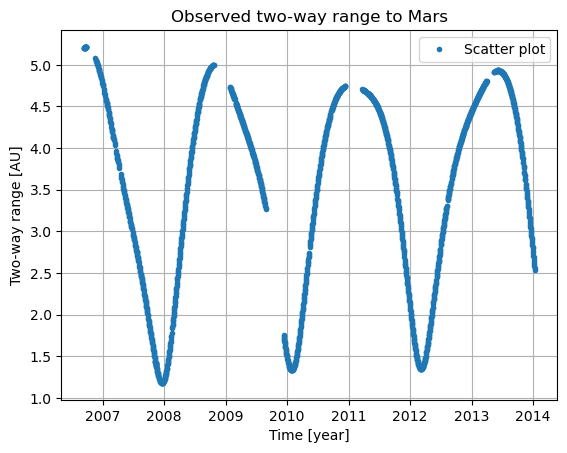

In [5]:
observation_times = np.array(observations.concatenated_times)
observation_vals = observations.concatenated_observations
observation_times_year = observation_times / constants.JULIAN_YEAR + 2000


plt.figure()
plt.title("Observed two-way range to Mars")
plt.plot(observation_times_year, observation_vals / constants.ASTRONOMICAL_UNIT, ".", label="Scatter plot")
plt.xlabel("Time [year]")
plt.ylabel("Two-way range [AU]")
plt.legend()
plt.grid("on")
plt.show()

## Simulation

As we mentioned earlier, within this example we also aim to **mimic the loaded real observations** starting from **SPICE ephemerides**. To achieve this, the first step is to load the standard SPICE kernels into our program.

In [6]:
spice.load_standard_kernels()

## Create Bodies

We then continue to set up the environment by creating the relevant bodies and applying their default body settings. A global frame with origin at Solar System Barycenter (SSB) and J2000 orientation is chosen. For this example, we want to show the influence of adding a more precise rotation model, so a simple utility function is introduced to create the bodies.


In [7]:
def create_bodies(use_itrf_rotation_model: bool = False) -> environment.SystemOfBodies:
    # Create default body settings
    bodies_to_create = ["Sun", "Earth", "Mars"]
    global_frame_origin = "SSB"
    global_frame_orientation = "J2000"
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create, global_frame_origin, global_frame_orientation
    )

    # Add ground stations DSN
    body_settings.get("Earth").ground_station_settings = environment_setup.ground_station.dsn_stations()
    bodies = environment_setup.create_system_of_bodies(body_settings)

    # Rotation model
    if use_itrf_rotation_model:
        body_settings.get("Earth").rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
            environment_setup.rotation_model.iau_2006, global_frame_orientation
        )

    # Create system of bodies
    bodies = environment_setup.create_system_of_bodies(body_settings)
    return bodies


bodies = create_bodies()

## Create Simulated observations

To simulate observations, we need three main things:

* Observation simulators, defining which observation types need to be simulated and which linkends need to be used.
* Observation simulation settings, defining the times at which to simulate the observations.
* The system of bodies relevant for the simulation

Do check out the [documentation](https://docs.tudat.space/en/latest/_src_user_guide/state_estimation/observation_simulation.html#simulating-the-observations) for a more rigorous explanation of the technicalities.

The system of bodies was already defined above, and all the other required information is in the collection of real observations that were loaded from the data file. For the observation simulation settings, there is a convenience function that extracts the settings from the collection `observation_settings_from_collection`. Creating the simulators is slightly more involved, as we need to specify the correct link definition for every observation - recall that the measurements are made using a variety of ground station.

In [8]:
# Extract the relevant information from the real observations to mimic
linkdef_ids = observations.concatenated_link_definition_ids
distinct_linkdefs = observations.get_link_definitions_for_observables(observation.n_way_range_type)

# Create the observation model settings to match those of the real observations
observation_model_settings = [
    estimation_setup.observation.n_way_range(distinct_linkdefs[linkdef_id]) for linkdef_id in linkdef_ids
]

def create_observations(observation_model_settings, bodies):
    # Create the observation simulators
    observation_simulators = estimation_setup.create_observation_simulators(observation_model_settings, bodies)

    # Get the simulator settings directly from the real observations
    observation_simulation_settings = estimation_setup.observation.observation_settings_from_collection(observations)

    # Simulate the observations
    simulated_observations = estimation.simulate_observations(observation_simulation_settings, observation_simulators, bodies)

    return simulated_observations

# Simulate the observations
simulated_observations_simple = create_observations(observation_model_settings, bodies)

### Simple simulation
For the first attempt, we don't include any corrections. This implies that the simulation will simply calculate the Euclidean distance that the light travels between the link ends. Plotting the difference between that and the observations reveals an error that grows with the distance between Earth and Mars. The larger the distance, the more that range is underestimated by the simple simulation. Additionally, there is some spread of the residuals, that seems to be related to a phenomenon of much higher frequency.

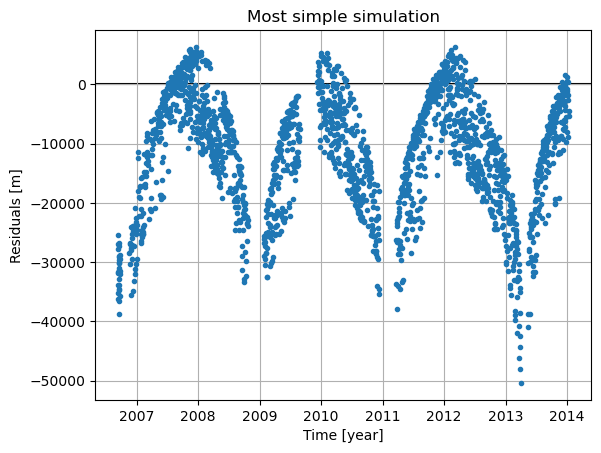

In [9]:
residuals_simple = simulated_observations_simple.concatenated_observations - observation_vals

plt.figure()
plt.plot(observation_times_year, residuals_simple, ".")
plt.title("Most simple simulation")
plt.xlabel("Time [year]")
plt.ylabel("Residuals [m]")
plt.grid("on")
plt.axhline(0, color="k", zorder=0)
plt.show()

### Improving the rotation model

One reason that might come to mind for the residual spread is that **the position of the ground stations is not accurately modelled over time**. This is indeed due to the simplifications in the default rotation model. If we create the bodies using the rotation model according to the **IERS 2010 models**, the spread is completely eliminated.

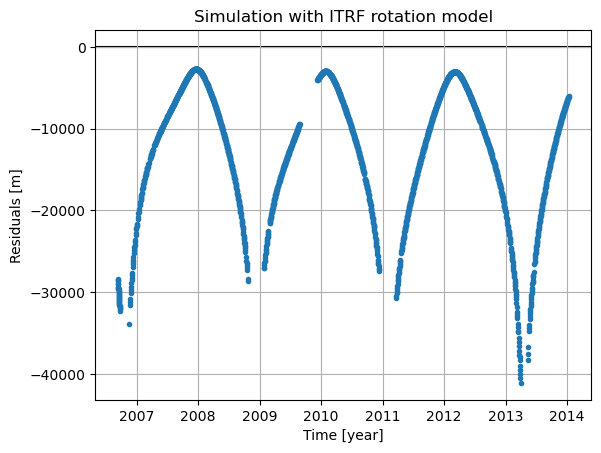

In [10]:
bodies_rotation = create_bodies(use_itrf_rotation_model=True)
simulated_observations_rotation = create_observations(observation_model_settings, bodies_rotation)
residuals_rotation = simulated_observations_rotation.concatenated_observations - observation_vals

plt.figure()
plt.plot(observation_times_year, residuals_rotation, ".")
plt.title("Simulation with ITRF rotation model")
plt.xlabel("Time [year]")
plt.ylabel("Residuals [m]")
plt.grid("on")
plt.axhline(0, color="k", zorder=0)
plt.show()

## Adding light time corrections

After adjusting the rotation model, it is clear that the simulation systematically underestimates the range. This seems to behave asymptotically as the distance between Mars and Earth increases, but notice that there are no measurements in the most extreme regions. At those times, the Sun is in the way, preventing useful observations. This also indicates that the presence of the Sun influences the travel time of the light. 

To account for the **relativistic effects due to the Sun**, we can add a *light time correction* to the settings of the observation model. 
Doing this and once more plotting the residuals shows that **the error signal related to the Earth-Mars synodic period is removed**, leaving a residual that oscillates annually in the order **a few hundreds of meters**. 

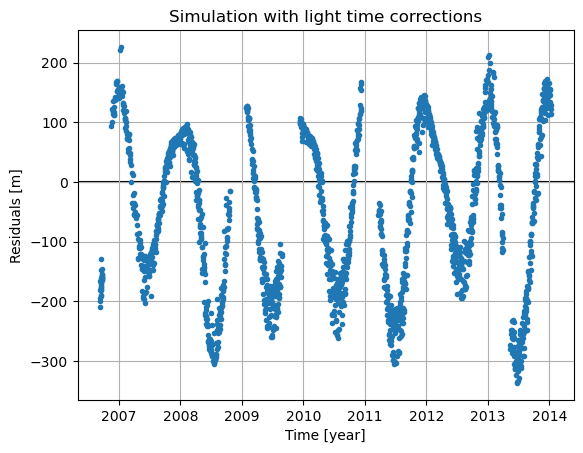

In [11]:
#  Create light time corrections
light_time_correction_list =[
        estimation_setup.observation.first_order_relativistic_light_time_correction(["Sun"])
]

observation_model_settings_lighttime = [
    estimation_setup.observation.n_way_range(distinct_linkdefs[linkdef_id], light_time_correction_list) for linkdef_id in linkdef_ids
]

simulated_observations_lighttime = create_observations(observation_model_settings_lighttime, bodies_rotation)
residuals_lighttime = simulated_observations_lighttime.concatenated_observations - observation_vals

# Plot the new residuals
plt.figure()
plt.plot(observation_times_year, residuals_lighttime, ".")
plt.title("Simulation with light time corrections")
plt.xlabel("Time [year]")
plt.ylabel("Residuals [m]")
plt.grid("on")
plt.axhline(0, color="k", zorder=0)
plt.show()

## Summary Plot

The following plot just summarises the observation simulation efforts of this example. You could go on to reduce the residuals to several meters (see [Kuchynka et al., 2012](https://ipnpr.jpl.nasa.gov/progress_report/42-190/190C.pdf) for details). This indicates **some small, but important imperfections in our algorithms**, for instance simplifications used in the time conversions between the time stamps in the files, and the times used in our simulations. The residuals indicate (among others) **a periodic trend at the Earth's orbital period around the Sun**.

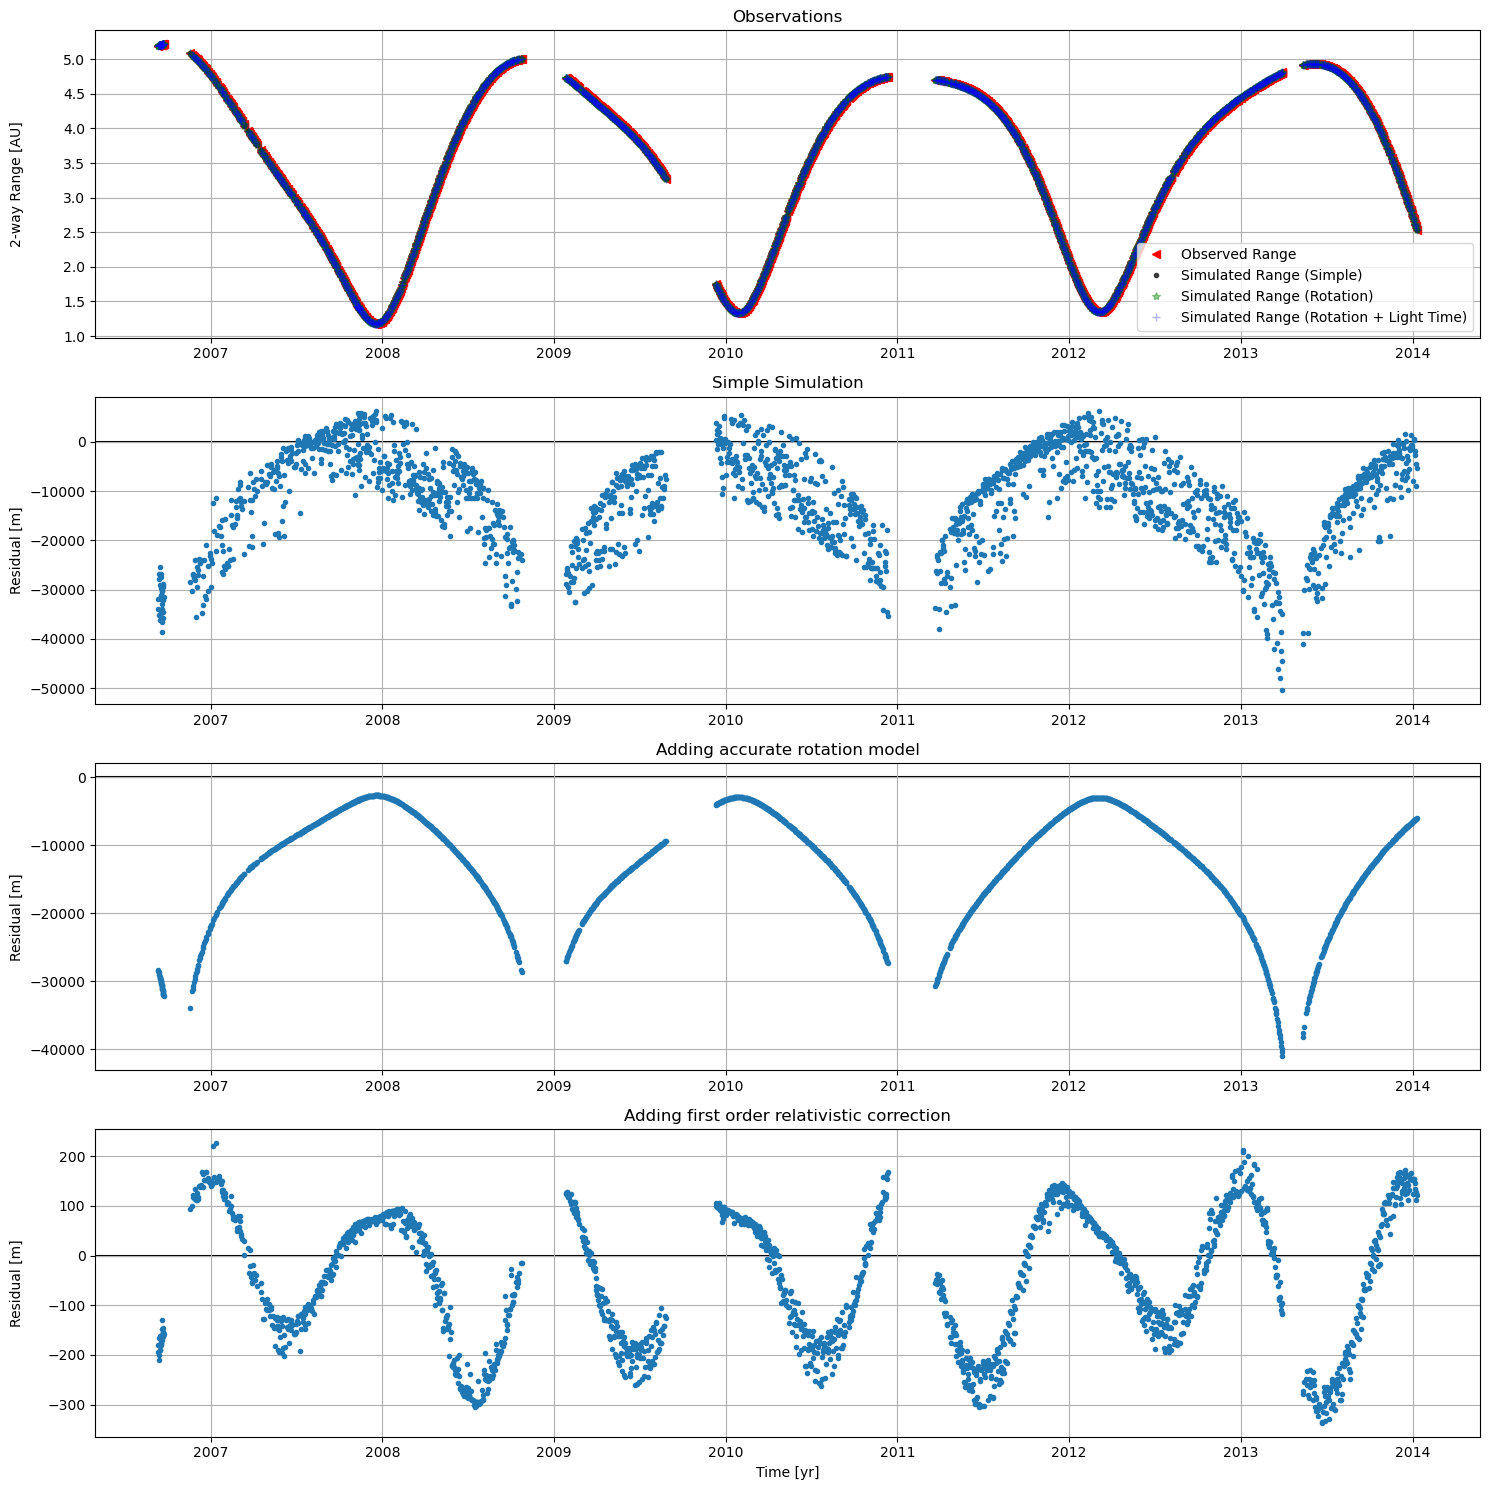

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(15, 15))

# Plot the observed and simulated range
ax[0].plot(
    observation_times_year,
    observation_vals / constants.ASTRONOMICAL_UNIT,
    "r<",
    label="Observed Range",
)

ax[0].plot(
    observation_times_year,
    simulated_observations_simple.concatenated_observations / constants.ASTRONOMICAL_UNIT,
    "k.",
    label="Simulated Range (Simple)", alpha = 0.7
)
ax[0].plot(
    observation_times_year,
    simulated_observations_rotation.concatenated_observations / constants.ASTRONOMICAL_UNIT,
    "g*",
    label="Simulated Range (Rotation)", alpha = 0.4
)


ax[0].plot(
    observation_times_year,
    simulated_observations_lighttime.concatenated_observations / constants.ASTRONOMICAL_UNIT,
    "b+",
    label="Simulated Range (Rotation + Light Time)", alpha = 0.3
)


ax[0].set_ylabel("2-way Range [AU]")
ax[0].legend()
ax[0].set_title("Observations")

# Plot the residuals

ax[1].set_title("Simple Simulation")
ax[1].plot(observation_times_year , residuals_simple, ".")

ax[2].set_title("Adding accurate rotation model")
ax[2].plot(observation_times_year, residuals_rotation, ".")

ax[3].set_title("Adding first order relativistic correction")
ax[3].plot(observation_times_year, residuals_lighttime, ".")

[ax_i.axhline(0, color="k", linestyle="-", zorder=0) for ax_i in ax[1:]]
[ax_i.set_ylabel("Residual [m]") for ax_i in ax[1:]]
[ax_i.grid("on", zorder=0) for ax_i in ax]
ax[-1].set_xlabel("Time [yr]")
fig.align_labels()
fig.tight_layout()
plt.show()